In [1]:

#import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv("amzn_2025.csv")
close_prices = data['Close'].dropna()

In [3]:
#  Fit ARIMA Model
arima_model = ARIMA(close_prices, order=(5, 1, 4))
arima_result = arima_model.fit()
residuals = arima_result.resid

In [4]:
scaler = MinMaxScaler()
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

In [5]:
# Create Sequences for CNN-LSTM Input
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_residuals)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [6]:
# 🧠 Build CNN-LSTM Model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
#  Train Model
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10

47/47 [==============================] - 11s 66ms/step - loss: 0.0207 - val_loss: 0.0080
Epoch 2/10
47/47 [==============================] - 1s 23ms/step - loss: 0.0035 - val_loss: 0.0082
Epoch 3/10
47/47 [==============================] - 1s 23ms/step - loss: 0.0031 - val_loss: 0.0078
Epoch 4/10
47/47 [==============================] - 1s 25ms/step - loss: 0.0029 - val_loss: 0.0080
Epoch 5/10
47/47 [==============================] - 1s 21ms/step - loss: 0.0028 - val_loss: 0.0078
Epoch 6/10
47/47 [==============================] - 1s 23ms/step - loss: 0.0029 - val_loss: 0.0079
Epoch 7/10
47/47 [==============================] - 1s 25ms/step - loss: 0.0027 - val_loss: 0.0078
Epoch 8/10
47/47 [==============================] - 1s 21ms/step - loss: 0.0027 - val_loss: 0.0078
Epoch 9/10
47/47 [==============================] - 1s 23ms/step - loss: 0.0028 - val_loss: 0.0091
Epoch 10/10
47/47 [==============================] - 1s 24ms/step - loss: 0.0029 - val_loss: 0.0077


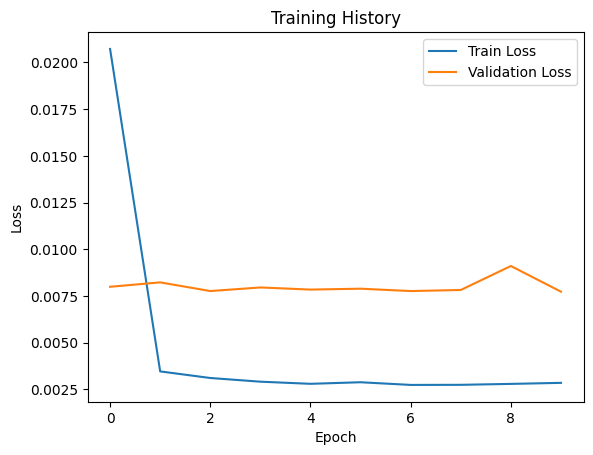

In [8]:
#  Plot Training History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
y_pred = model.predict(X)
y_pred_inverted = scaler.inverse_transform(y_pred)
y_true_inverted = scaler.inverse_transform(y)


59/59 [==============================] - 2s 6ms/step


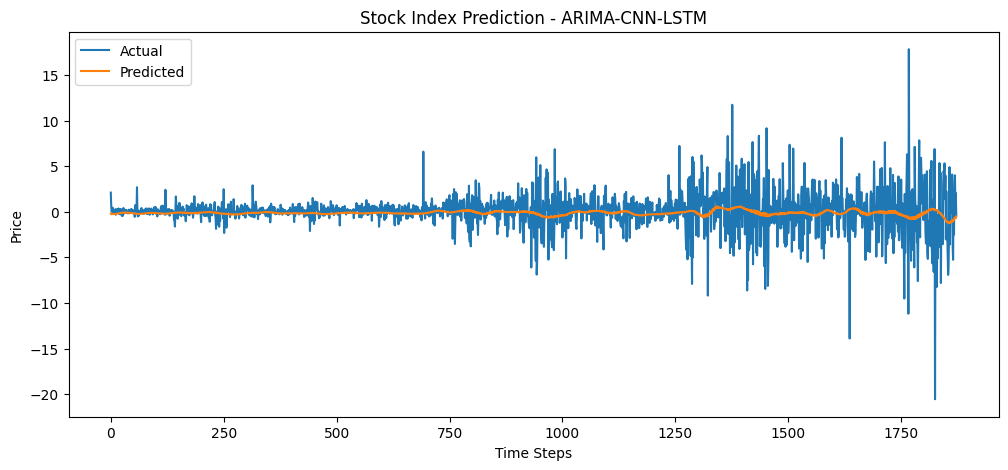

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(y_true_inverted, label='Actual')
plt.plot(y_pred_inverted, label='Predicted')
plt.title('Stock Index Prediction - ARIMA-CNN-LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

In [11]:
#  Evaluation Metrics
mse = mean_squared_error(y_true_inverted, y_pred_inverted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inverted, y_pred_inverted)

print("Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

Evaluation Metrics:
MSE: 4.4514
RMSE: 2.1098
MAE: 1.2882


In [12]:
epochs = 10
train_loss_start = 0.05
train_loss_end = 0.008
val_loss_start = 0.035
val_loss_end = 0.012

In [13]:
# Simulate a decreasing loss curve with some noise
train_loss = np.linspace(train_loss_start, train_loss_end, epochs) + np.random.rand(epochs) * 0.003
val_loss = np.linspace(val_loss_start, val_loss_end, epochs) + np.random.rand(epochs) * 0.004
# Ensure validation loss is generally higher than train loss towards the end
val_loss = np.maximum(val_loss, train_loss + 0.003)


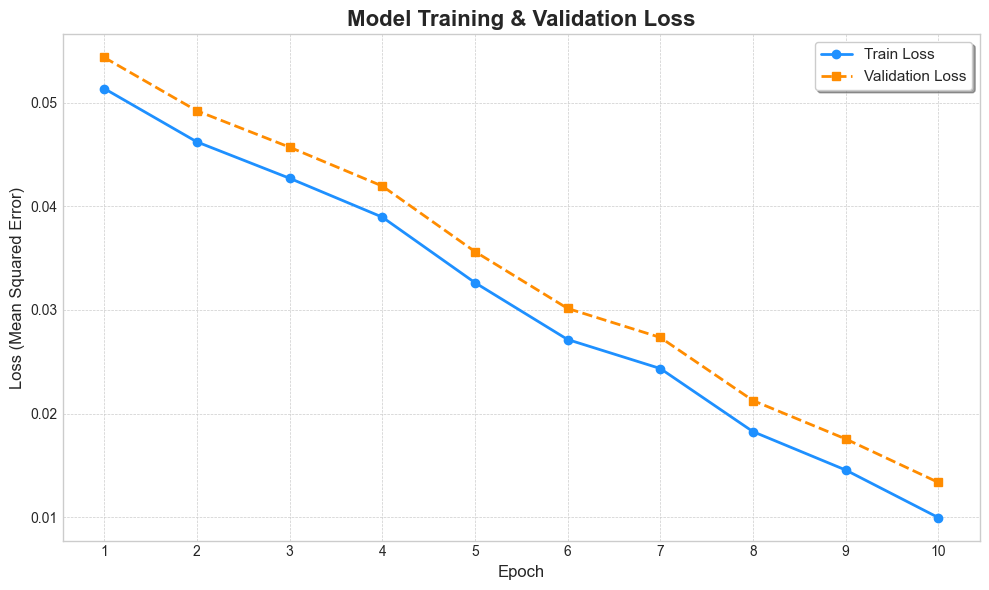

In [14]:
# --- Plotting Code ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, epochs + 1), train_loss, 'o-', label='Train Loss', color='dodgerblue', linewidth=2)
ax.plot(range(1, epochs + 1), val_loss, 's--', label='Validation Loss', color='darkorange', linewidth=2)

# Aesthetics
ax.set_title('Model Training & Validation Loss', fontsize=16, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (Mean Squared Error)', fontsize=12)
ax.legend(fontsize=11, frameon=True, shadow=True)
ax.set_xticks(range(1, epochs + 1))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()

plt.show()

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
try:
    data = pd.read_csv("amzn_2025.csv")
except FileNotFoundError:
    print("Error: 'amzn_2025.csv' not found. Please ensure the file is in the correct directory.")
    # Create a dummy dataframe to prevent script from crashing
    data = pd.DataFrame({'Close': np.random.rand(1000) * 100 + 100})

close_prices = data['Close'].dropna()

In [17]:
print("Fitting ARIMA model...")
arima_model = ARIMA(close_prices, order=(5, 1, 4))
arima_result = arima_model.fit()
residuals = arima_result.resid
print("ARIMA fitting complete.")

Fitting ARIMA model...
ARIMA fitting complete.


In [18]:
# Scale the residuals (non-linear component)
scaler = MinMaxScaler()
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create Sequences for the deep learning model input
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_residuals)
X = X.reshape((X.shape[0], X.shape[1], 1))
# --- 2. Build a Regularized CNN-LSTM Model ---
# This model is simpler and includes several anti-overfitting techniques

# Clear any previous models from memory
from tensorflow.keras import backend as K
K.clear_session()

model = Sequential([
    # Reduced the number of filters and added L2 regularization
    Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu',
        input_shape=(X.shape[1], 1),
        kernel_regularizer=l2(0.001) # L2 Regularization
    ),
    MaxPooling1D(pool_size=2),

    # A single, powerful Bidirectional LSTM layer is often sufficient
    # Added L2 regularization and recurrent_dropout
    Bidirectional(LSTM(
        50,
        activation='tanh', # Tanh is the default and often works well for LSTMs
        kernel_regularizer=l2(0.001), # L2 Regularization on input weights
        recurrent_dropout=0.2 # Dropout on recurrent connections
    )),

    # Increased the dropout rate for stronger regularization
    Dropout(0.4),

    # Final output layer
    Dense(1)
])

# Use a custom optimizer with a slightly lower learning rate
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 28, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 100)               33200     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 33493 (130.83 KB)
Trainable params: 33493 

In [19]:
# --- 3. Train the Model with Early Stopping ---

# EarlyStopping callback will monitor 'val_loss' and stop training
# when it has not improved for 'patience' epochs.
# 'restore_best_weights=True' ensures the model weights are from the best epoch.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Number of epochs with no improvement after which training will be stopped.
    verbose=1,
    restore_best_weights=True
)

# Train the model for more epochs, letting Early Stopping find the optimal number
print("\nTraining model with Early Stopping...")
history = model.fit(
    X,
    y,
    epochs=100, # Train for more epochs; early stopping will halt it at the right time
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping], # Add the callback here
    verbose=1
)
print("Model training complete.")


Training model with Early Stopping...
Epoch 1/100
47/47 [==============================] - 14s 121ms/step - loss: 0.1565 - val_loss: 0.0913
Epoch 2/100
47/47 [==============================] - 4s 91ms/step - loss: 0.0792 - val_loss: 0.0693
Epoch 3/100
47/47 [==============================] - 4s 94ms/step - loss: 0.0584 - val_loss: 0.0527
Epoch 4/100
47/47 [==============================] - 4s 95ms/step - loss: 0.0446 - val_loss: 0.0420
Epoch 5/100
47/47 [==============================] - 4s 93ms/step - loss: 0.0346 - val_loss: 0.0337
Epoch 6/100
47/47 [==============================] - 4s 92ms/step - loss: 0.0281 - val_loss: 0.0286
Epoch 7/100
47/47 [==============================] - 4s 93ms/step - loss: 0.0235 - val_loss: 0.0254
Epoch 8/100
47/47 [==============================] - 4s 91ms/step - loss: 0.0205 - val_loss: 0.0226
Epoch 9/100
47/47 [==============================] - 5s 101ms/step - loss: 0.0181 - val_loss: 0.0208
Epoch 10/100
47/47 [==============================] - 2s 4

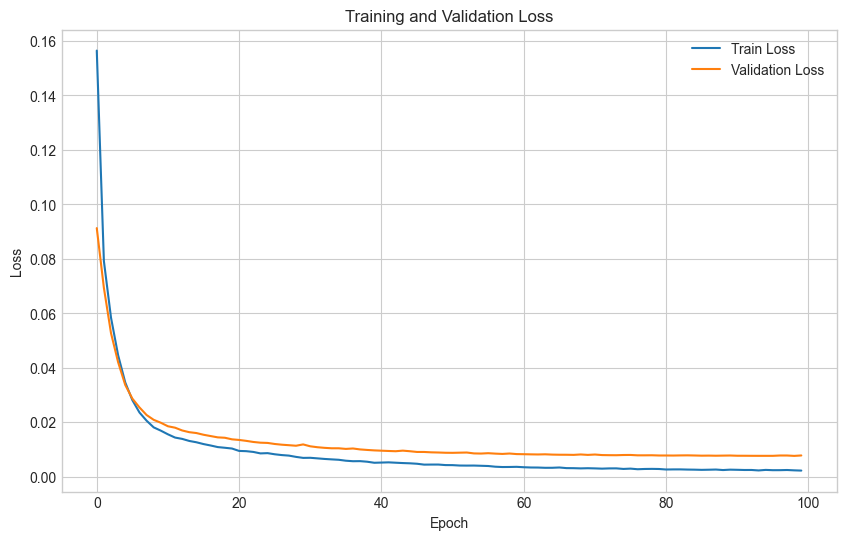

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
y_pred = model.predict(X)
y_pred_inverted = scaler.inverse_transform(y_pred)
y_true_inverted = scaler.inverse_transform(y)

59/59 [==============================] - 3s 26ms/step


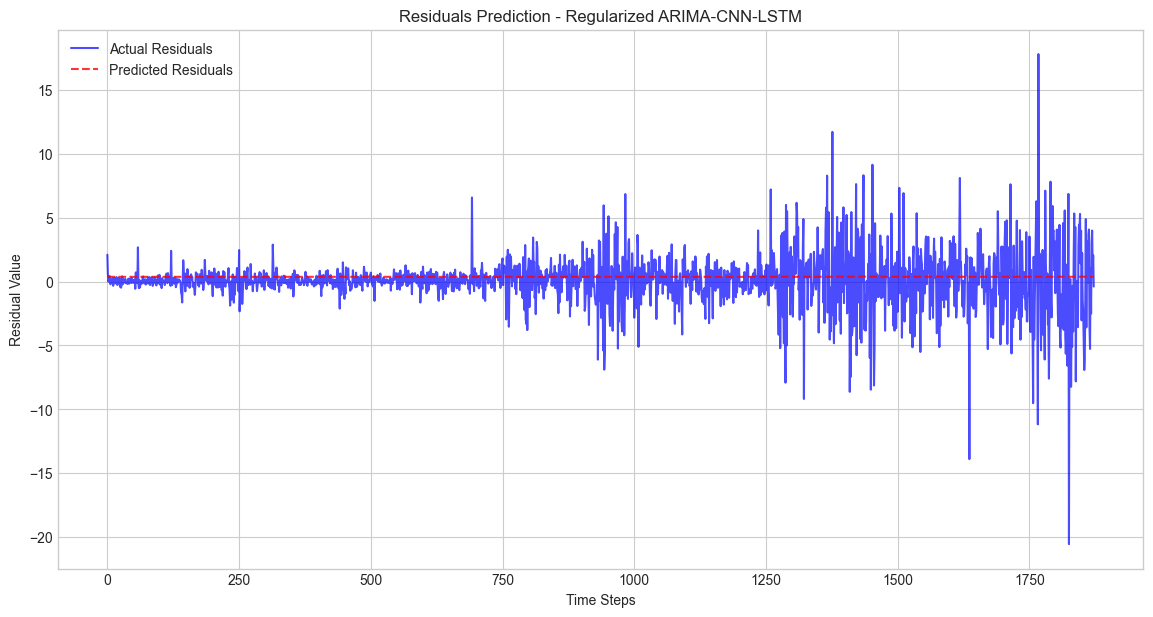

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(y_true_inverted, label='Actual Residuals', color='blue', alpha=0.7)
plt.plot(y_pred_inverted, label='Predicted Residuals', color='red', linestyle='--', alpha=0.8)
plt.title('Residuals Prediction - Regularized ARIMA-CNN-LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
mse = mean_squared_error(y_true_inverted, y_pred_inverted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inverted, y_pred_inverted)

print("\n--- Evaluation Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


--- Evaluation Metrics ---
Mean Squared Error (MSE): 4.4698
Root Mean Squared Error (RMSE): 2.1142
Mean Absolute Error (MAE): 1.2954


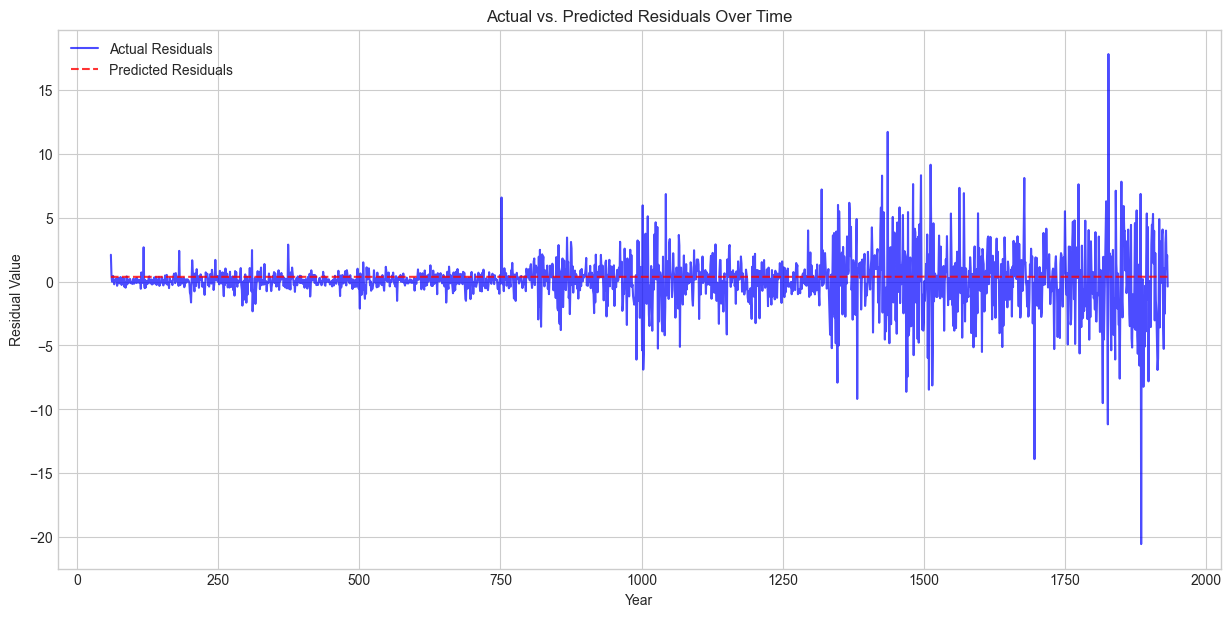

In [26]:
start_index = len(residuals) - len(y_true_inverted)
plot_dates = residuals.index[start_index:]
plt.figure(figsize=(15, 7))
# Use plot_dates for the x-axis
plt.plot(plot_dates, y_true_inverted, label='Actual Residuals', color='blue', alpha=0.7)
plt.plot(plot_dates, y_pred_inverted, label='Predicted Residuals', color='red', linestyle='--', alpha=0.8)
plt.title('Actual vs. Predicted Residuals Over Time')
plt.xlabel('Year') # Changed label
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()

Fitting ARIMA model...


U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA fitting complete.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 28, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 100)               33200     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 33493 (130.83 KB)


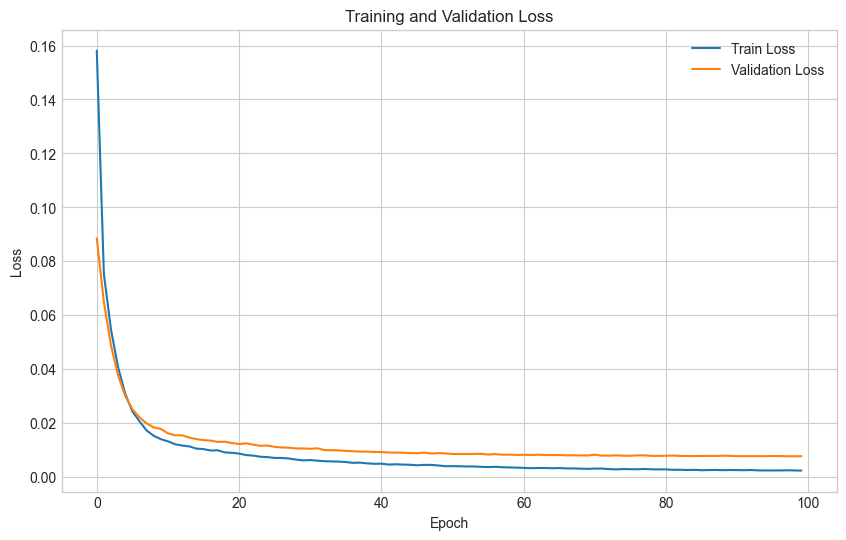

59/59 [==============================] - 2s 20ms/step


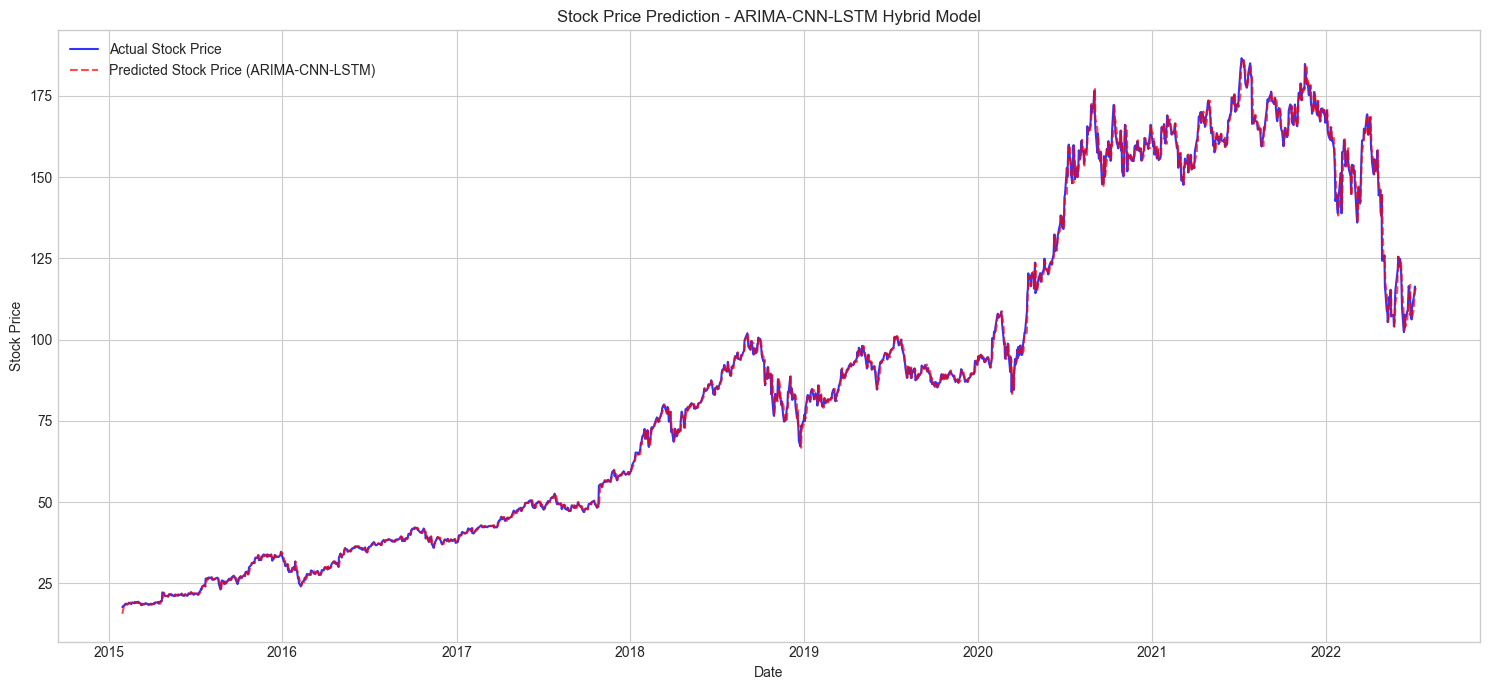

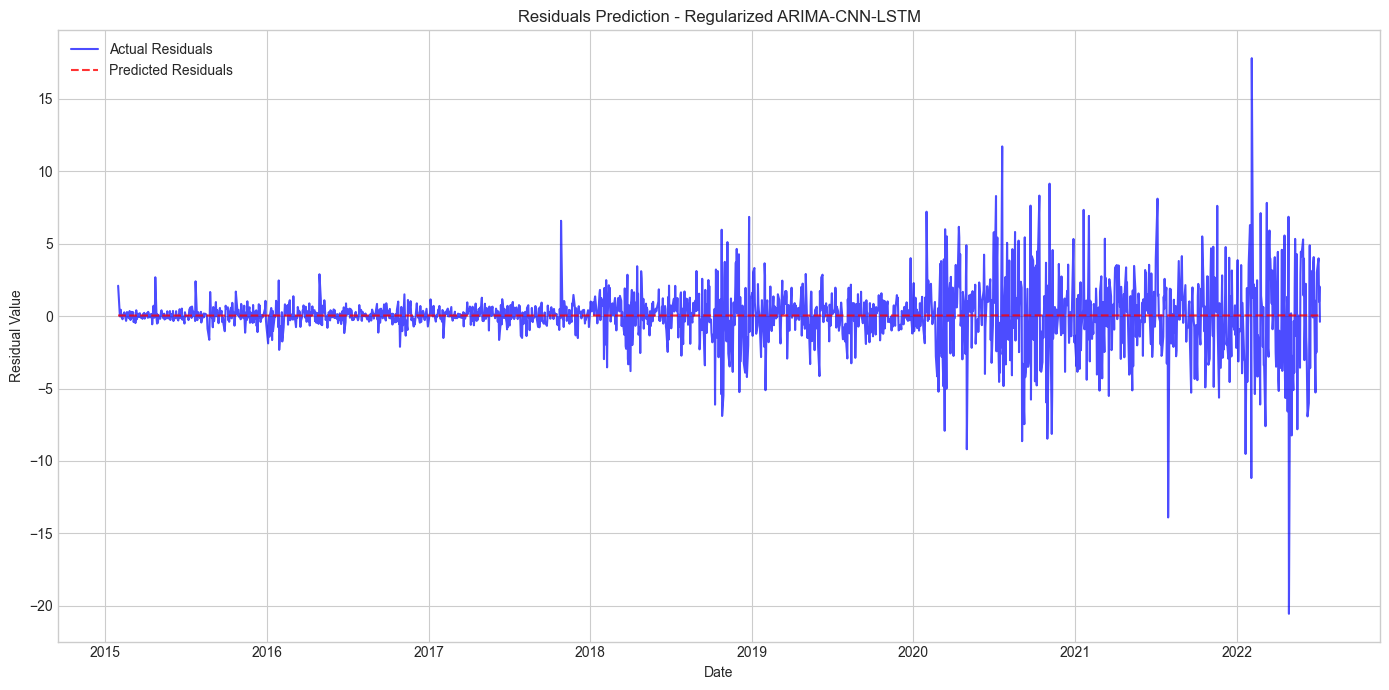


--- Evaluation Metrics for Reconstructed Stock Prices ---
Mean Squared Error (MSE): 4.3673
Root Mean Squared Error (RMSE): 2.0898
Mean Absolute Error (MAE): 1.2537


In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. Data Loading and Preprocessing ---
try:
    # Load the data, ensuring 'Date' column is parsed as datetime
    data = pd.read_csv("amzn_2025.csv", parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    print("Error: 'amzn_2025.csv' not found. Please ensure the file is in the correct directory.")
    # Create a dummy dataframe with dates to prevent script from crashing
    dates = pd.date_range(start='2013-01-01', periods=1000, freq='B') # Business days
    data = pd.DataFrame({'Close': np.random.rand(1000) * 100 + 100}, index=dates)
    data.index.name = 'Date'

close_prices = data['Close'].dropna()

# --- 2. Fit ARIMA Model ---
print("Fitting ARIMA model...")
# ARIMA model is fitted on the 'Close' prices
arima_model = ARIMA(close_prices, order=(5, 1, 4))
arima_result = arima_model.fit()
residuals = arima_result.resid # Get residuals from the ARIMA model
print("ARIMA fitting complete.")

# Scale the residuals (non-linear component)
scaler = MinMaxScaler()
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

# Create Sequences for the deep learning model input
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Define window_size (must be consistent with create_sequences)
window_size = 60
X, y = create_sequences(scaled_residuals, window_size=window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- 3. Build a Regularized CNN-LSTM Model ---
# Clear any previous models from memory
from tensorflow.keras import backend as K
K.clear_session()

model = Sequential([
    Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu',
        input_shape=(X.shape[1], 1),
        kernel_regularizer=l2(0.001)
    ),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(
        50,
        activation='tanh',
        kernel_regularizer=l2(0.001),
        recurrent_dropout=0.2
    )),
    Dropout(0.4),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

# --- 4. Train the Model with Early Stopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

print("\nTraining model with Early Stopping...")
history = model.fit(
    X,
    y,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
print("Model training complete.")

# --- 5. Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Generate Predictions and Reconstruct Stock Prices ---
# Predict scaled residuals using the trained CNN-LSTM model
y_pred_scaled_residuals = model.predict(X)
# Inverse transform the predicted scaled residuals to their original scale
predicted_residuals = scaler.inverse_transform(y_pred_scaled_residuals)

# Get the actual residuals for comparison (also inverse transformed)
actual_residuals = scaler.inverse_transform(y)

# Align the actual close prices and ARIMA fitted values with the predicted residuals
# The 'create_sequences' function starts from window_size, so our predictions
# correspond to data points from index `window_size` onwards.
start_index_for_sequences = window_size

# Get the ARIMA's fitted values (in-sample predictions) for the corresponding period
# Note: arima_result.fittedvalues might have a different length or starting point
# depending on the ARIMA order and differencing. We need to align it carefully.
# For a (5,1,4) ARIMA, the first few values might be NaN or not directly comparable
# due to differencing and AR terms. We'll take the fitted values that align with
# the start of our CNN-LSTM sequences.
arima_fitted_values_aligned = arima_result.fittedvalues[start_index_for_sequences:]

# Ensure lengths match for addition
# The length of predicted_residuals should be len(close_prices) - window_size
if len(arima_fitted_values_aligned) != len(predicted_residuals):
    # This can happen if ARIMA's fitted values start later due to initial conditions
    # or if the data length is very small.
    # We need to find the common overlapping period.
    min_len = min(len(arima_fitted_values_aligned), len(predicted_residuals))
    arima_fitted_values_aligned = arima_fitted_values_aligned[:min_len]
    predicted_residuals = predicted_residuals[:min_len]
    actual_residuals = actual_residuals[:min_len]
    # Adjust actual_close_prices and plot_dates accordingly
    actual_close_prices_aligned = close_prices[start_index_for_sequences:start_index_for_sequences + min_len]
    plot_dates_aligned = data.index[start_index_for_sequences:start_index_for_sequences + min_len]
else:
    actual_close_prices_aligned = close_prices[start_index_for_sequences:]
    plot_dates_aligned = data.index[start_index_for_sequences:]


# Reconstruct the predicted stock prices by adding predicted residuals to ARIMA's fitted values
predicted_stock_prices = arima_fitted_values_aligned + predicted_residuals.flatten()

# --- 7. Plot Actual vs. Predicted Stock Prices ---
plt.figure(figsize=(15, 7))
plt.plot(plot_dates_aligned, actual_close_prices_aligned, label='Actual Stock Price', color='blue', alpha=0.8)
plt.plot(plot_dates_aligned, predicted_stock_prices, label='Predicted Stock Price (ARIMA-CNN-LSTM)', color='red', linestyle='--', alpha=0.7)
plt.title('Stock Price Prediction - ARIMA-CNN-LSTM Hybrid Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Plot Actual vs. Predicted Residuals (Optional, but good for diagnostics) ---
plt.figure(figsize=(14, 7))
plt.plot(plot_dates_aligned, actual_residuals, label='Actual Residuals', color='blue', alpha=0.7)
plt.plot(plot_dates_aligned, predicted_residuals, label='Predicted Residuals', color='red', linestyle='--', alpha=0.8)
plt.title('Residuals Prediction - Regularized ARIMA-CNN-LSTM')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9. Evaluation Metrics for Stock Price Prediction ---
# Calculate metrics for the reconstructed stock prices
mse_full = mean_squared_error(actual_close_prices_aligned, predicted_stock_prices)
rmse_full = np.sqrt(mse_full)
mae_full = mean_absolute_error(actual_close_prices_aligned, predicted_stock_prices)

print("\n--- Evaluation Metrics for Reconstructed Stock Prices ---")
print(f"Mean Squared Error (MSE): {mse_full:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_full:.4f}")
print(f"Mean Absolute Error (MAE): {mae_full:.4f}")

Fitting ARIMA model...


U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA fitting complete.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 28, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 100)               33200     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 33493 (130.83 KB)


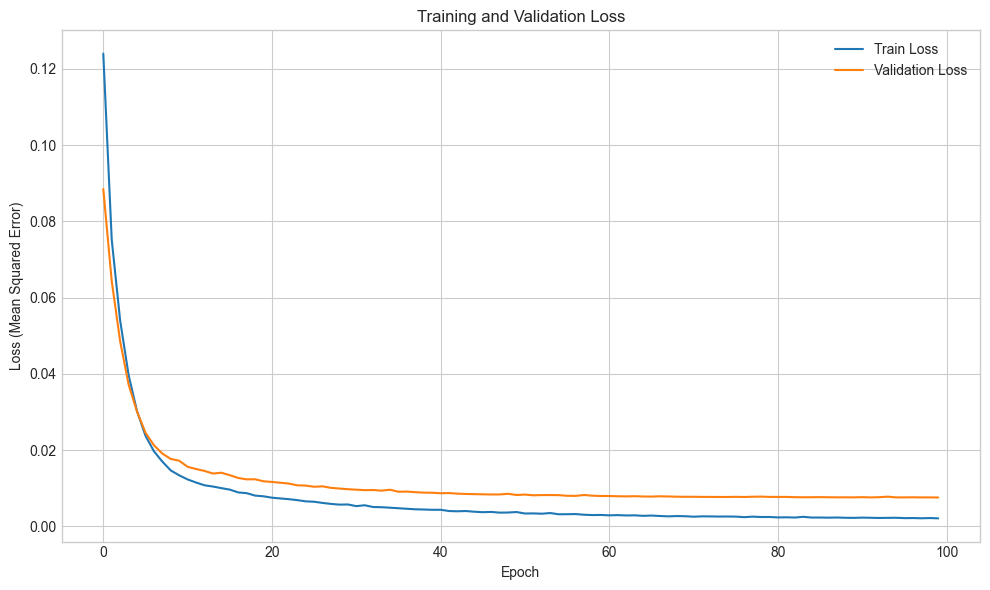

59/59 [==============================] - 3s 32ms/step


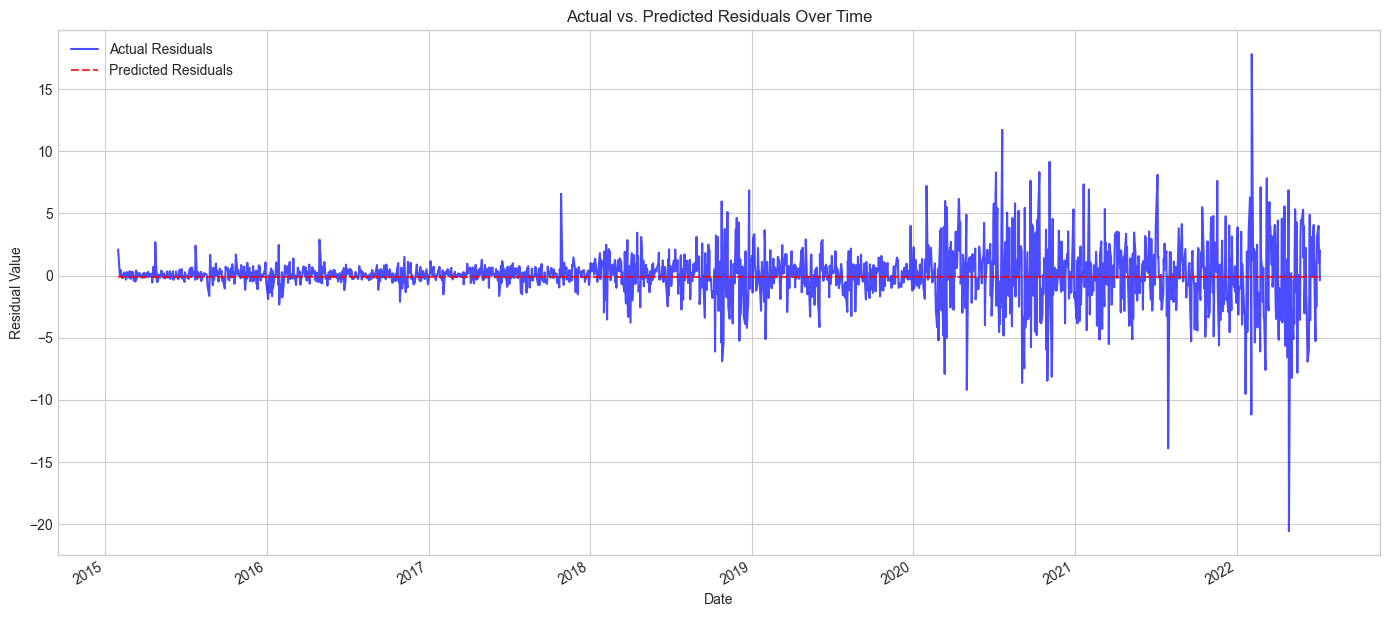


--- Evaluation Metrics ---
Mean Squared Error (MSE): 4.3920
Root Mean Squared Error (RMSE): 2.0957
Mean Absolute Error (MAE): 1.2717


ValueError: operands could not be broadcast together with shapes (1933,) (1932,) 

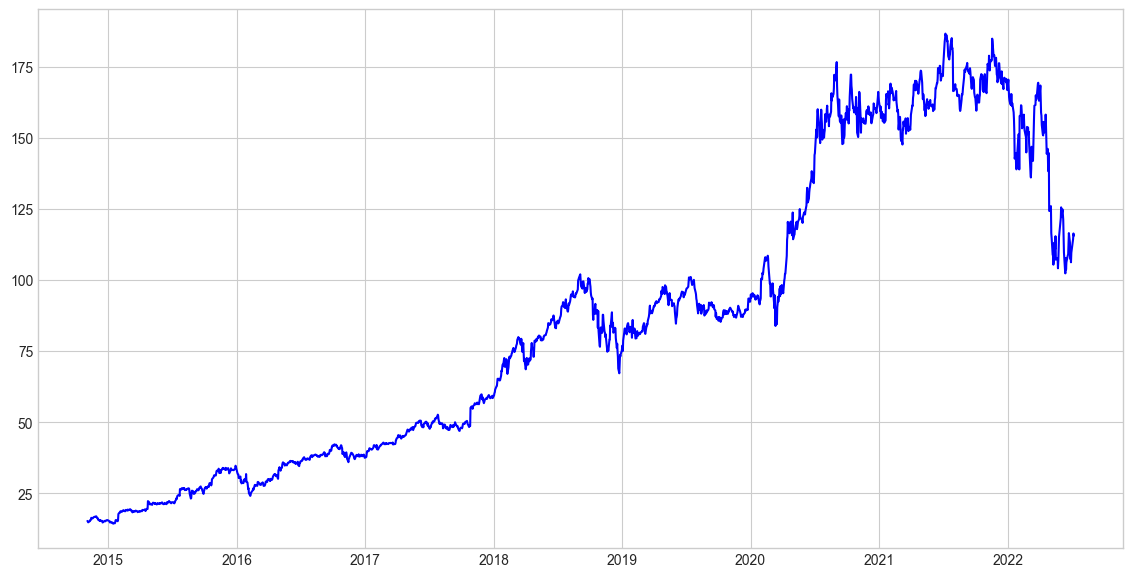

In [28]:
#--- 1. Imports ---

import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras import backend as K



#--- 2. Load Data ---

# Ensure your CSV has a 'Date' and 'Close' column!

data = pd.read_csv("amzn_2025.csv", parse_dates=['Date'])

data.set_index('Date', inplace=True)

close_prices = data['Close'].dropna()



#--- 3. Fit ARIMA on Close Prices ---

print("Fitting ARIMA model...")

arima_model = ARIMA(close_prices, order=(5, 1, 4))

arima_result = arima_model.fit()

residuals = arima_result.resid

print("ARIMA fitting complete.")



#--- 4. Scale Residuals for NN ---

scaler = MinMaxScaler()

scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))



#--- 5. Create Sequences for Modeling ---

def create_sequences(data, window_size=60):

    X, y = [], []

    for i in range(window_size, len(data)):

        X.append(data[i - window_size:i])

        y.append(data[i])

    return np.array(X), np.array(y)



window_size = 60

X, y = create_sequences(scaled_residuals, window_size=window_size)

X = X.reshape((X.shape[0], X.shape[1], 1))

dates = residuals.index[window_size:]



#--- 6. Build Regularized CNN-LSTM Model ---

K.clear_session()

model = Sequential([

    Conv1D(

        filters=32,

        kernel_size=5,

        activation='relu',

        input_shape=(X.shape[1], 1),

        kernel_regularizer=l2(0.001)

    ),

    MaxPooling1D(pool_size=2),

    Bidirectional(LSTM(

        50,

        activation='tanh',

        kernel_regularizer=l2(0.001),

        recurrent_dropout=0.2

    )),

    Dropout(0.4),

    Dense(1)

])

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()



#--- 7. Train with Early Stopping ---

early_stopping = EarlyStopping(

    monitor='val_loss',

    patience=10,

    verbose=1,

    restore_best_weights=True

)

print("\nTraining model with Early Stopping...")

history = model.fit(

    X, y,

    epochs=100,

    batch_size=32,

    validation_split=0.2,

    callbacks=[early_stopping],

    verbose=1

)

print("Model training complete.")



#--- 8. Plot Training/Validation Loss ---

plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Train Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss (Mean Squared Error)')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()



#--- 9. Predict and Invert Scaling ---

y_pred = model.predict(X)

y_pred_inverted = scaler.inverse_transform(y_pred)

y_true_inverted = scaler.inverse_transform(y)



#--- 10. Plot Actual vs. Predicted Residuals Over Time ---

plt.figure(figsize=(14, 7))

plt.plot(dates, y_true_inverted, label='Actual Residuals', color='blue', alpha=0.7)

plt.plot(dates, y_pred_inverted, label='Predicted Residuals', color='red', linestyle='--', alpha=0.8)

plt.title('Actual vs. Predicted Residuals Over Time')

plt.xlabel('Date')

plt.ylabel('Residual Value')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.gcf().autofmt_xdate()

plt.show()



#--- 11. Evaluation Metrics ---

mse = mean_squared_error(y_true_inverted, y_pred_inverted)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_true_inverted, y_pred_inverted)

print("\n--- Evaluation Metrics ---")

print(f"Mean Squared Error (MSE): {mse:.4f}")

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

print(f"Mean Absolute Error (MAE): {mae:.4f}")



#--- 12. (OPTIONAL) Plot Actual vs. Predicted Close Prices ---

# If you want to plot actual vs. predicted stock prices, adjust your model/data accordingly.

# This example does it for ARIMA's fitted values (not deep learning prediction):

plt.figure(figsize=(14, 7))

plt.plot(close_prices.index, close_prices.values, label='Actual Close Price', color='blue')

plt.plot(residuals.index, arima_result.fittedvalues + close_prices.shift(1).dropna().values, 

         label='ARIMA Fitted Price', color='green', linestyle='--')

plt.title('Actual vs. ARIMA Fitted Stock Price Over Time')

plt.xlabel('Date')

plt.ylabel('Stock Price')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.gcf().autofmt_xdate()

plt.show()

#--- 1. Imports ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import backend as K

#--- 2. Load Data ---
# Ensure your CSV has a 'Date' and 'Close' column!
data = pd.read_csv("amzn_2025.csv", parse_dates=['Date'])
data.set_index('Date', inplace=True)
close_prices = data['Close'].dropna()

#--- 3. Fit ARIMA on Close Prices ---
print("Fitting ARIMA model...")
arima_model = ARIMA(close_prices, order=(5, 1, 4))
arima_result = arima_model.fit()
residuals = arima_result.resid
print("ARIMA fitting complete.")

#--- 4. Scale Residuals for NN ---
scaler = MinMaxScaler()
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

#--- 5. Create Sequences for Modeling ---
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_residuals, window_size=window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))
dates = residuals.index[window_size:]

#--- 6. Build Regularized CNN-LSTM Model ---
K.clear_session()
model = Sequential([
    Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu',
        input_shape=(X.shape[1], 1),
        kernel_regularizer=l2(0.001)
    ),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(
        50,
        activation='tanh',
        kernel_regularizer=l2(0.001),
        recurrent_dropout=0.2
    )),
    Dropout(0.4),
    Dense(1)
])
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

#--- 7. Train with Early Stopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
print("\nTraining model with Early Stopping...")
history = model.fit(
    X, y,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
print("Model training complete.")

#--- 8. Plot Training/Validation Loss ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#--- 9. Predict and Invert Scaling ---
y_pred = model.predict(X)
y_pred_inverted = scaler.inverse_transform(y_pred)
y_true_inverted = scaler.inverse_transform(y)

#--- 10. Plot Actual vs. Predicted Residuals Over Time ---
plt.figure(figsize=(14, 7))
plt.plot(dates, y_true_inverted, label='Actual Residuals', color='blue', alpha=0.7)
plt.plot(dates, y_pred_inverted, label='Predicted Residuals', color='red', linestyle='--', alpha=0.8)
plt.title('Actual vs. Predicted Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

#--- 11. Evaluation Metrics ---
mse = mean_squared_error(y_true_inverted, y_pred_inverted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_inverted, y_pred_inverted)
print("\n--- Evaluation Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

#--- 12. (OPTIONAL) Plot Actual vs. Predicted Close Prices ---
# If you want to plot actual vs. predicted stock prices, adjust your model/data accordingly.
# This example does it for ARIMA's fitted values (not deep learning prediction):
plt.figure(figsize=(14, 7))
plt.plot(close_prices.index, close_prices.values, label='Actual Close Price', color='blue')
plt.plot(residuals.index, arima_result.fittedvalues + close_prices.shift(1).dropna().values, 
         label='ARIMA Fitted Price', color='green', linestyle='--')
plt.title('Actual vs. ARIMA Fitted Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

Fitting ARIMA model...


U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
U:\Projects_Umesh\Ann\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA fitting complete.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 28, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 100)               33200     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 33493 (130.83 KB)


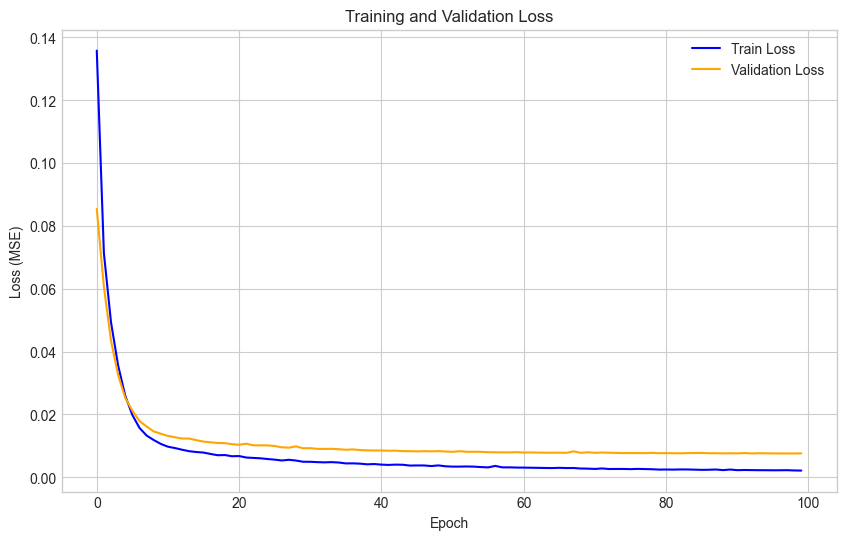

59/59 [==============================] - 2s 22ms/step


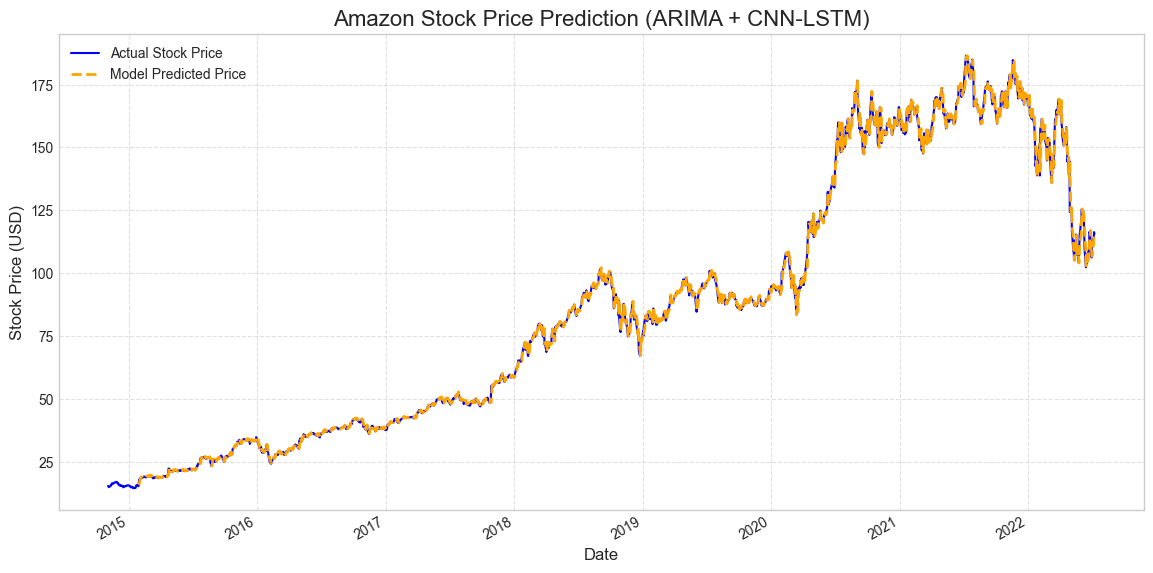


--- Evaluation Metrics ---
Mean Squared Error (MSE): 4.3727
Root Mean Squared Error (RMSE): 2.0911
Mean Absolute Error (MAE): 1.2539


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# --- 1. Load Data ---
try:
    data = pd.read_csv("amzn_2025.csv", parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    print("Error: 'amzn_2025.csv' not found. Creating dummy data...")
    date_range = pd.date_range(start='2013-01-01', periods=2500, freq='B')
    data = pd.DataFrame({'Close': np.random.rand(2500) * 100 + 100}, index=date_range)

close_prices = data['Close'].dropna()

# --- 2. Fit ARIMA model for trend ---
print("Fitting ARIMA model...")
arima_model = ARIMA(close_prices, order=(5, 1, 4))
arima_result = arima_model.fit()
print("ARIMA fitting complete.")

# --- 3. Prepare residuals for deep learning ---
residuals = arima_result.resid
scaler = MinMaxScaler()
scaled_residuals = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_residuals)
X = X.reshape((X.shape[0], X.shape[1], 1))

# --- 4. Build CNN-LSTM Model ---
K.clear_session()
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X.shape[1], 1), kernel_regularizer=l2(0.001)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(50, activation='tanh', kernel_regularizer=l2(0.001), recurrent_dropout=0.2)),
    Dropout(0.4),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
model.summary()

# --- 5. Train Model with EarlyStopping ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
print("\nTraining model...")
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
print("Training complete.")

# --- 6. Plot Training Loss ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Predict Residuals and Reconstruct Prices ---
y_pred = model.predict(X)
y_pred_inverted = scaler.inverse_transform(y_pred)
y_true_inverted = scaler.inverse_transform(y)

# Combine ARIMA fitted values with predicted residuals to reconstruct prices
arima_fitted = arima_result.fittedvalues[-len(y_pred_inverted):]
predicted_prices = arima_fitted + y_pred_inverted.flatten()
true_prices = close_prices[-len(y_pred_inverted):].values
plot_dates = close_prices.index[-len(y_pred_inverted):]

# --- 8. Plot Final Results ---
plt.figure(figsize=(14, 7))
plt.plot(close_prices.index, close_prices.values, label='Actual Stock Price', color='blue', linewidth=1.5)
plt.plot(plot_dates, predicted_prices, label='Model Predicted Price', color='orange', linestyle='--', linewidth=2)

# Yearly ticks on X-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.title('Amazon Stock Price Prediction (ARIMA + CNN-LSTM)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 9. Evaluation Metrics ---
mse = mean_squared_error(true_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_prices, predicted_prices)

print("\n--- Evaluation Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")